In [86]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
from tqdm import tqdm_notebook

import datetime as dtime
import pandas_datareader.data as web

In [87]:
# 各パラメータを定義
# 過去20日の値を入力→5日後の株価を予測
N = 20
horizon = 5

# 学習率
lr = 1e-3

# training
batch_size = 100
num_epoch = 100

In [88]:
source = "stooq"  # データ読み込み元のサーバー 

# 取得範囲の指定
start_date = dtime.datetime(2018, 1, 1)
end_date = dtime.date.today()

# ニューモント・マイニング(米国の金鉱株)
ticker_symbol = "NEM.US"
stockdata = web.DataReader(ticker_symbol, source, start_date, end_date)

# 金ETF
ticker_symbol_2 = "GLD.US"
stockdata_2 = web.DataReader(ticker_symbol_2, source, start_date, end_date)

# ダウ平均株価
ticker_symbol_3 = "^DJI"
stockdata_3 = web.DataReader(ticker_symbol_3, source, start_date, end_date)

# WTI原油ETF
ticker_symbol_4 = "USO.US"
stockdata_4 = web.DataReader(ticker_symbol_4, source, start_date, end_date)

# ドル円ETF(インベスコ・カレンシーシェアーズ・日本円・トラスト)
ticker_symbol_5 = "FXY.US"
stockdata_5 = web.DataReader(ticker_symbol_4, source, start_date, end_date)

# 米国債(3-7年)ETF
ticker_symbol_6 = "IEI.US"
stockdata_6 = web.DataReader(ticker_symbol_4, source, start_date, end_date)

In [89]:
# stockdataの中身を確認
stockdata

,Open,High,Low,Close,Volume
Date,,,,,
2023-04-06,51.6000,52.1599,51.0400,52.0500,8.461312e+06
2023-04-05,51.7400,52.7600,51.1900,52.0700,1.176784e+07
2023-04-04,49.2800,51.5400,49.1400,51.3500,1.472098e+07
2023-04-03,49.0100,49.6950,48.3900,49.4700,6.309516e+06
2023-03-31,48.9050,49.0400,48.4700,49.0200,5.832536e+06
...,...,...,...,...,...
2018-01-08,33.2395,33.3875,32.9009,33.2482,5.445552e+06
2018-01-05,33.0935,33.3082,32.9532,33.2830,3.319357e+06
2018-01-04,32.7180,33.1602,32.3902,33.1602,4.471442e+06


<Axes: xlabel='Date'>

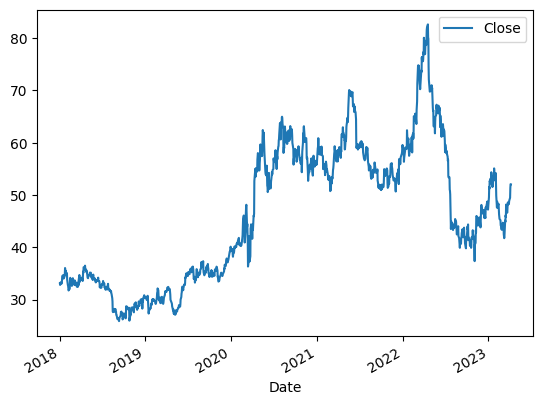

In [90]:
# stockdataの終値の推移をグラフで確認してみる
stockdata.plot(y="Close")

In [91]:
# 各データ(ニューモント・マイニングの終値と出来高、その他の終値)をNumpy形式に変換
close_values = stockdata["Close"].to_numpy()
volume_values = stockdata["Volume"].to_numpy()
close_values_2 = stockdata_2["Close"].to_numpy()
close_values_3 = stockdata_3["Close"].to_numpy()
close_values_4 = stockdata_4["Close"].to_numpy()
close_values_5 = stockdata_5["Close"].to_numpy()
close_values_6 = stockdata_6["Close"].to_numpy()

In [92]:
# 正規化、逆変換を行う関数を生成する関数を定義
def generate_normalizers(ave, std):
    def normalize(data):
        data = np.asarray(data)
        return (data - ave) / std

    def denormalize(data):
        data = np.asarray(data)
        return data * std + ave

    return normalize, denormalize

In [93]:
# 平均と標準偏差を計算
close_ave = np.mean(close_values)
close_std = np.std(close_values)

volume_ave = np.mean(volume_values)
volume_std = np.std(volume_values)

close2_ave = np.mean(close_values_2)
close2_std = np.std(close_values_2)

close3_ave = np.mean(close_values_3)
close3_std = np.std(close_values_3)

close4_ave = np.mean(close_values_4)
close4_std = np.std(close_values_4)

close5_ave = np.mean(close_values_5)
close5_std = np.std(close_values_5)

close6_ave = np.mean(close_values_6)
close6_std = np.std(close_values_6)

# 正規化関数を生成
normalize_close, denormalize_close = generate_normalizers(close_ave, close_std)
normalize_valume, _ = generate_normalizers(volume_ave, volume_std)
normalize_close2, _ = generate_normalizers(close2_ave, close2_std)
normalize_close3, _ = generate_normalizers(close3_ave, close3_std)
normalize_close4, _ = generate_normalizers(close4_ave, close4_std)
normalize_close5, _ = generate_normalizers(close5_ave, close5_std)
normalize_close6, _ = generate_normalizers(close6_ave, close6_std)

# 正規化
close_values_ = normalize_close(close_values)
volume_values_ = normalize_valume(volume_values)
close_values_2_ = normalize_close2(close_values_2)
close_values_3_ = normalize_close3(close_values_3)
close_values_4_ = normalize_close4(close_values_4)
close_values_5_ = normalize_close5(close_values_5)
close_values_6_ = normalize_close6(close_values_6)

In [9]:
# データをtrainとtestに分割する関数
def divide(values):
    values_train = values[stockdata.index <= dtime.datetime(2021, 12, 31)]  # 2018-2021年までが学習用
    values_train = values_train[::-1]  # 古い順にソート

    values_test = values[stockdata.index >= dtime.datetime(2022, 1, 1)]  # 2022年-今日までがテスト用
    values_test = values_test[::-1]  # 古い順にソート

    return values_train, values_test

In [10]:
# 各valuesをtrainとtestに分割
close_values_train, close_values_test = divide(close_values_)
volume_values_train, volume_values_test = divide(volume_values_)
close_values_2_train, close_values_2_test = divide(close_values_2_)
close_values_3_train, close_values_3_test = divide(close_values_3_)
close_values_4_train, close_values_4_test = divide(close_values_4_)
close_values_5_train, close_values_5_test = divide(close_values_5_)
close_values_6_train, close_values_6_test = divide(close_values_6_)

In [11]:
# 入力データと出力データを切り出す関数
def retrieve_data(k, values):
    # 入力xと出力yを同時に切り出すためのインデックス
    ks = k + np.arange(N + horizon)

    # 切り出し
    retrieved_values = values[ks]

    x = retrieved_values[:N]  # 前半N個が入力値
    y = retrieved_values[-1:]   # 最後が予測したい数字

    return x, y

In [73]:
# 訓練データを作成
xtrain1 = [] # stockdataの終値と出来高
xtrain2 = [] # stockdata,stockdata2の終値
xtrain3 = [] # stockdata,stockdata3の終値
xtrain4 = [] # stockdata,stockdata2,4の終値
xtrain5 = [] # stockdata,stockdata2,3,4の終値
xtrain6 = [] # すべての終値

ytrain = [] 

for k in tqdm_notebook(range(len(close_values_train) - N - horizon)):
    close_x, close_y = retrieve_data(k, close_values_train)
    volume_x, _ = retrieve_data(k, volume_values_train)
    close_x2, _ = retrieve_data(k, close_values_2_train)
    close_x3, _ = retrieve_data(k, close_values_3_train)
    close_x4, _ = retrieve_data(k, close_values_4_train)
    close_x5, _ = retrieve_data(k, close_values_5_train)
    close_x6, _ = retrieve_data(k, close_values_6_train)

    x1 = np.vstack([close_x, volume_x])
    x2 = np.vstack([close_x, close_x2])
    x3 = np.vstack([close_x, close_x3])
    x4 = np.vstack([close_x, close_x2, close_x4])
    x5 = np.vstack([close_x, close_x2, close_x3, close_x4])
    x6 = np.vstack([close_x, close_x2, close_x3, close_x4, close_x5, close_x6])

    xtrain1.append(x1)
    xtrain2.append(x2)
    xtrain3.append(x3)
    xtrain4.append(x4)
    xtrain5.append(x5)
    xtrain6.append(x6)
    ytrain.append(close_y)

<ipython-input-73-93f58ffe7a74>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(len(close_values_train) - N - horizon)):


  0%|          | 0/983 [00:00<?, ?it/s]

In [94]:
# テストデータを作成
xtest1 = [] # stockdataの終値と出来高
xtest2 = [] # stockdata,stockdata2の終値
xtest3 = [] # stockdata,stockdata3の終値
xtest4 = [] # stockdata,stockdata2,4の終値
xtest5 = [] # stockdata,stockdata2,3,4の終値
xtest6 = [] # すべての終値

ytest = [] 

for k in tqdm_notebook(range(len(close_values_test) - N - horizon)):
    close_x, close_y = retrieve_data(k, close_values_test)
    volume_x, _ = retrieve_data(k, volume_values_test)
    close_x2, _ = retrieve_data(k, close_values_2_test)
    close_x3, _ = retrieve_data(k, close_values_3_test)
    close_x4, _ = retrieve_data(k, close_values_4_test)
    close_x5, _ = retrieve_data(k, close_values_5_test)
    close_x6, _ = retrieve_data(k, close_values_6_test)

    x1 = np.vstack([close_x, volume_x])
    x2 = np.vstack([close_x, close_x2])
    x3 = np.vstack([close_x, close_x3])
    x4 = np.vstack([close_x, close_x2, close_x4])
    x5 = np.vstack([close_x, close_x2, close_x3, close_x4])
    x6 = np.vstack([close_x, close_x2, close_x3, close_x4, close_x5, close_x6])

    xtest1.append(x1)
    xtest2.append(x2)
    xtest3.append(x3)
    xtest4.append(x4)
    xtest5.append(x5)
    xtest6.append(x6)
    ytest.append(close_y)

<ipython-input-94-8154c53dc077>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(len(close_values_test) - N - horizon)):


  0%|          | 0/292 [00:00<?, ?it/s]

In [14]:
# データセットを定義するクラス
class MyDataset(Dataset):

    def __init__(self, xs, ys):
        super().__init__()
        self.xs = xs
        self.ys = ys
    
    def __getitem__(self, index):
        x = self.xs[index]
        y = self.ys[index]

        np_x = np.asarray(x)
        np_y = np.asarray(y)

        th_x = th.from_numpy(np_x).float()
        th_y = th.from_numpy(np_y).float()

        return th_x, th_y
    
    def __len__(self):
        return len(self.xs)

In [98]:
# データセットを作成
train_dataset1 = MyDataset(xtrain1, ytrain)
train_dataset2 = MyDataset(xtrain2, ytrain)
train_dataset3 = MyDataset(xtrain3, ytrain)
train_dataset4 = MyDataset(xtrain4, ytrain)
train_dataset5 = MyDataset(xtrain5, ytrain)
train_dataset6 = MyDataset(xtrain6, ytrain)

test_dataset1 = MyDataset(xtest1, ytest)
test_dataset2 = MyDataset(xtest2, ytest)
test_dataset3 = MyDataset(xtest3, ytest)
test_dataset4 = MyDataset(xtest4, ytest)
test_dataset5 = MyDataset(xtest5, ytest)
test_dataset6 = MyDataset(xtest6, ytest)

In [112]:
# データローダーを定義
train_loader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
train_loader3 = DataLoader(train_dataset3, batch_size=batch_size, shuffle=True)
train_loader4 = DataLoader(train_dataset4, batch_size=batch_size, shuffle=True)
train_loader5 = DataLoader(train_dataset5, batch_size=batch_size, shuffle=True)
train_loader6 = DataLoader(train_dataset6, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(test_dataset1, batch_size=len(xtest1),shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=len(xtest1),shuffle=False)
test_loader3 = DataLoader(test_dataset3, batch_size=len(xtest1),shuffle=False)
test_loader4 = DataLoader(test_dataset4, batch_size=len(xtest1),shuffle=False)
test_loader5 = DataLoader(test_dataset5, batch_size=len(xtest1),shuffle=False)
test_loader6 = DataLoader(test_dataset6, batch_size=len(xtest1),shuffle=False)

In [79]:
def train(model, 
          lr, 
          criteria, 
          train_loader, 
          test_loader=None, 
          num_epoch=100, 
          show_fig=True, 
          time_series=False):
    opt = optim.Adam(model.parameters(), lr=lr)
    log_loss_train = []
    log_loss_test = []
    for e in range(num_epoch):
        epoch_losses = []
        for xs, ys in train_loader:
            # 時系列データへ変換     
            if time_series:
                xs = th.transpose(xs, 1, 2)
            # 予想
            predict = model(xs)
            # 損失関数
            loss = criteria(predict, ys)
            epoch_losses.append(loss.item())
            # 重みの更新
            opt.zero_grad()
            loss.backward()
            opt.step()    
        # trainのLogging
        epoch_loss = np.mean(epoch_losses)
        log_loss_train.append(epoch_loss)

        if test_loader is not None:
            for xs, ys in test_loader:
                # 時系列データへ変換
                if time_series:
                    xs = th.transpose(xs, 1, 2)
                # 予想
                predict = model(xs)
                # 損失関数
                loss = criteria(predict, ys)
            # testのLogging
            log_loss_test.append(loss.item())

        if show_fig and ((e+1) % 10) == 0:
            clear_output()
            fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
            # train
            axes[0].plot(log_loss_train, label="train")
            axes[1].plot(denormalize_close(ys.detach().numpy()), label="label")
            # test
            if test_loader is not None:
                axes[0].plot(log_loss_test, label="test")
                axes[1].plot(denormalize_close(predict.detach().numpy()), label="predict")

            plt.legend()
            plt.show()
    
    return log_loss_train, log_loss_test

In [18]:
# 損失関数の決定
criteria = nn.MSELoss()

In [19]:
class MyRNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.l_rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.l_lin = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x, h = self.l_rnn(x)
        x = self.l_lin(x[:, -1, :])
        return x

In [110]:
# 色々なパターンのモデルを用意
model_1 = MyRNN(2, 64, 1) 
model_2 = MyRNN(3, 64, 1) 
model_3 = MyRNN(4, 64, 1) 
model_4 = MyRNN(6, 64, 1) 

model_5 = MyRNN(3, 100, 1) 
model_6 = MyRNN(4, 100, 1) 

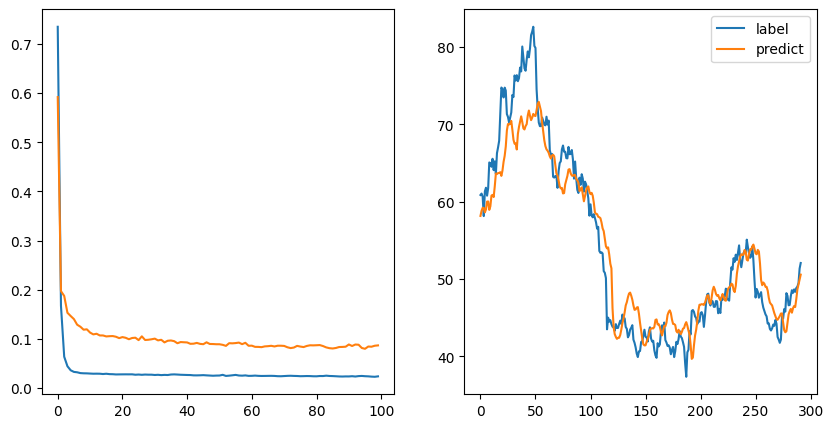

In [113]:
# dataset1,model_1でTrain
_ , _ = train(model_1, lr, criteria, train_loader1, test_loader1, num_epoch, show_fig=True, time_series=True)                               

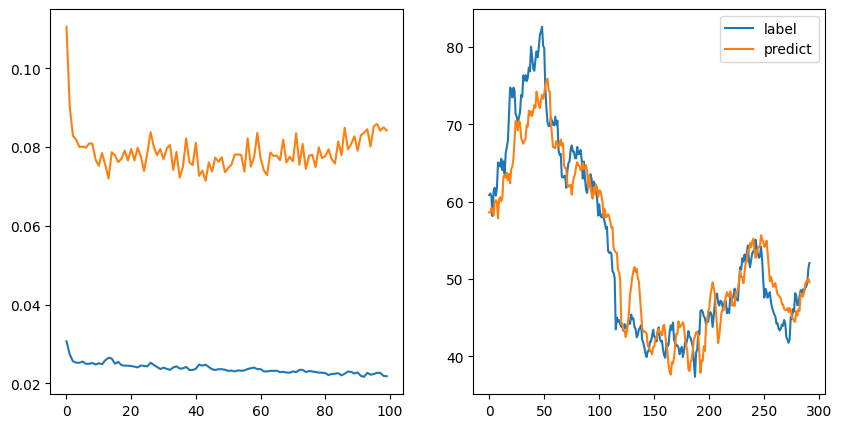

In [114]:
# dataset2,model_1でTrain
_ , _ = train(model_1, lr, criteria, train_loader2, test_loader2, num_epoch, show_fig=True, time_series=True)   

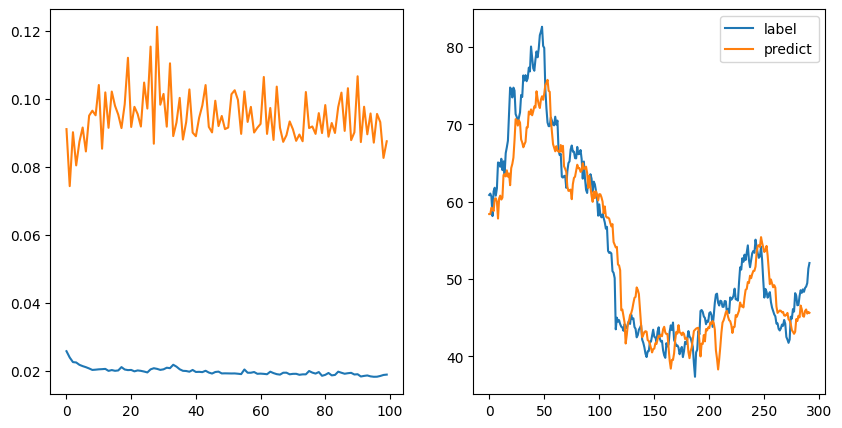

In [115]:
# dataset3,model_1でTrain
_ , _ = train(model_1, lr, criteria, train_loader3, test_loader3, num_epoch, show_fig=True, time_series=True)    

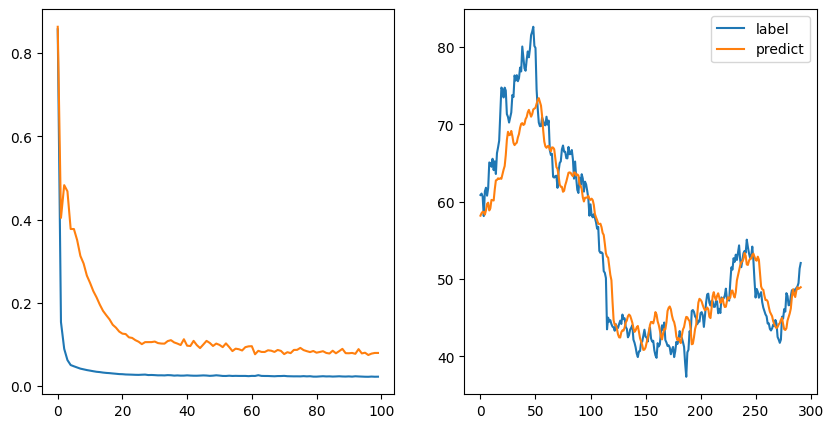

In [116]:
# dataset4,model_2でTrain
_ , _ = train(model_2, lr, criteria, train_loader4, test_loader4, num_epoch, show_fig=True, time_series=True)  

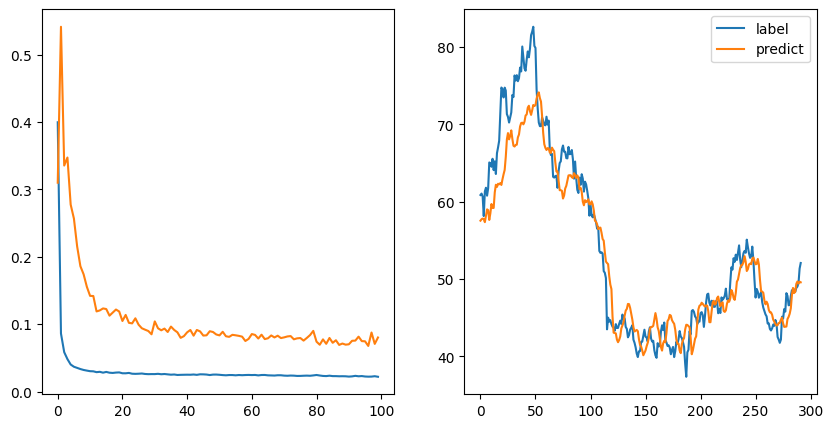

In [117]:
# dataset4,model_5でTrain (隠れ層を100に増やしてみる)
_ , _ = train(model_5, lr, criteria, train_loader4, test_loader4, num_epoch, show_fig=True, time_series=True)  

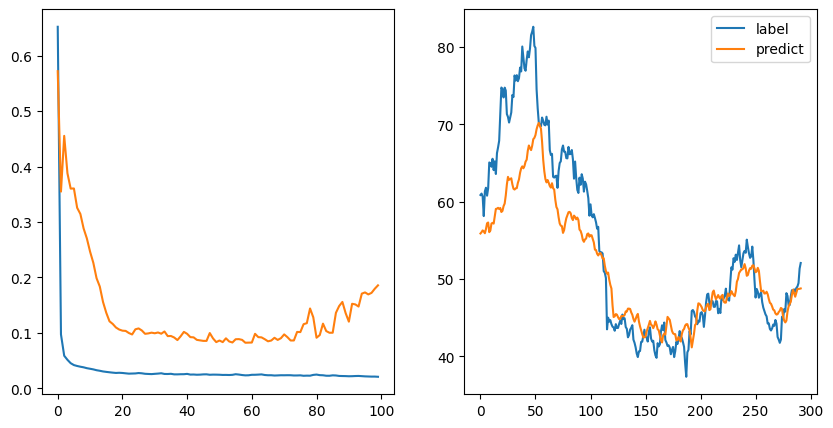

In [118]:
# dataset5,model_3でTrain
_ , _ = train(model_3, lr, criteria, train_loader5, test_loader5, num_epoch, show_fig=True, time_series=True)  

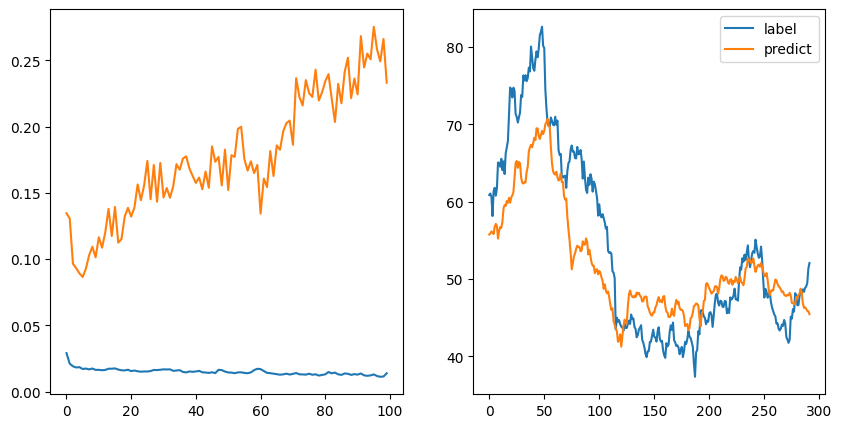

In [119]:
# dataset5,model_6でTrain
_ , _ = train(model_6, lr, criteria, train_loader5, test_loader5, num_epoch, show_fig=True, time_series=True)  

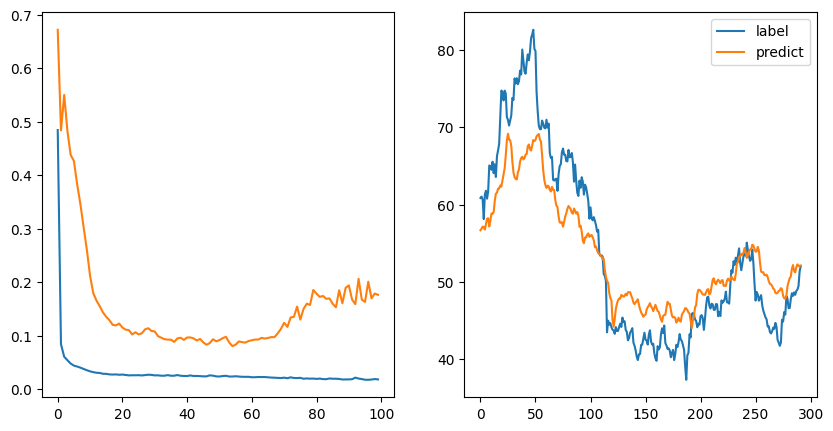

In [120]:
# dataset6,model_4でTrain
_ , _ = train(model_4, lr, criteria, train_loader6, test_loader6, num_epoch, show_fig=True, time_series=True)  